In [1]:
import time
from petitRADTRANS import Radtrans
import petitRADTRANS.retrieval_examples.emission.master_retrieval_model as rm
from petitRADTRANS import nat_cst as nc
import petitRADTRANS.rebin_give_width as rgw
from scipy.interpolate import interp1d
import sklearn

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import sys

from torch.distributions import Independent, Distribution
from fab_priors import BoxUniform_New

import torch
from sbi.inference import SNRE_A, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi.types import Array, OneOrMore, ScalarFloat

from Coverage_eval_SBI import Coverage_class

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=10_000)

In [2]:
op= '/home/mvasist/petitRADTRANS/petitRADTRANS/retrieval_examples/emission/'
observation_files = {}
observation_files['NIRISS SOSS'] = op +'NIRISS_SOSS_flux.dat'
observation_files['NIRSpec G395M'] = op +'NIRSpec_G395M_flux.dat'
observation_files['MIRI LRS'] = op +'MIRI_LRS_flux.dat'

# Wavelength range of observations, fixed parameters that will not be retrieved
WLENGTH = [0.3, 15.0] 
# LOG_G =  2.58
R_pl =   1.84*nc.r_jup_mean
R_star = 1.81*nc.r_sun
gamma = 1
t_equ= 0

# Get host star spectrum to calculate F_pl / F_star later.
T_star = 6295.
x = nc.get_PHOENIX_spec(T_star)
fstar = interp1d(x[:,0], x[:,1])

In [3]:
####################################################################################
####################################################################################
### READ IN OBSERVATION
####################################################################################
####################################################################################

# Read in data, convert all to cgs! 

'''
Im using only data_flux_nu_error['MIRI LRS'] from here to calculate the likelihood. 
'''

data_wlen = {}
data_flux_nu = {}
data_flux_nu_error = {}
data_wlen_bins = {}

for name in observation_files.keys():
    print(name)
    dat_obs = np.genfromtxt(observation_files[name])
    data_wlen[name] = dat_obs[:,0]*1e-4
    data_flux_nu[name] = dat_obs[:,1]
    data_flux_nu_error[name] = dat_obs[:,2]
    
    data_wlen_bins[name] = np.zeros_like(data_wlen[name])
    data_wlen_bins[name][:-1] = np.diff(data_wlen[name])
    data_wlen_bins[name][-1] = data_wlen_bins[name][-2]

NIRISS SOSS
NIRSpec G395M
MIRI LRS


In [4]:
def Simulator(params): 

    NaN_spectra = 0

    atmosphere = Radtrans(line_species = ['H2O', 'CO_all_iso', \
                                         'CO2', 'CH4', \
                                          'Na', 'K'], \
          rayleigh_species = ['H2', 'He'], \
          continuum_opacities = ['H2-H2', 'H2-He'], \
          wlen_bords_micron = WLENGTH)#, mode='c-k')


    pressures = np.logspace(-6, 2, 100)
    atmosphere.setup_opa_structure(pressures)
    temperature = 1200. * np.ones_like(pressures)

    
    t_int = params[0].numpy()                             #200.
    log_kappa_IR = params[1].numpy()                      #-2
    log_gravity = params[2].numpy()                       #params[5].numpy() 1e1**2.45 

    gravity = np.exp(log_gravity)
    kappa_IR = np.exp(log_kappa_IR)
    
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, t_int, t_equ)
    
    abundances = {}
    abundances['H2'] = np.exp(params[3].numpy())*np.ones_like(temperature)         #0.74 * np.ones_like(temperature) (params[3].numpy()) 0.75 * np.ones_like(temperature)
    abundances['He'] = np.exp(params[4].numpy())*np.ones_like(temperature)         #0.25 * np.ones_like(temperature)  #0.24 * np.ones_like(temperature) (params[4].numpy())
    abundances['H2O'] = np.exp(params[5].numpy())*np.ones_like(temperature)        #0.001 * np.ones_like(temperature)
    abundances['CO_all_iso'] = np.exp(params[6].numpy())*np.ones_like(temperature) #0.01 * np.ones_like(temperature)
    abundances['CO2'] = np.exp(params[7].numpy())*np.ones_like(temperature)        #0.00001 * np.ones_like(temperature)
    abundances['CH4'] = np.exp(params[8].numpy())*np.ones_like(temperature)        #0.000001 * np.ones_like(temperature)
    abundances['Na'] = np.exp(params[9].numpy())*np.ones_like(temperature)         #0.00001 * np.ones_like(temperature)
    abundances['K'] = np.exp(params[10].numpy())*np.ones_like(temperature)          #0.000001 * np.ones_like(temperature)

    MMW = rm.calc_MMW(abundances) * np.ones_like(temperature)
    
    atmosphere.calc_flux(temperature, abundances, gravity, MMW)

    wlen, flux_nu = nc.c/atmosphere.freq, atmosphere.flux/1e-6

    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(flux_nu)) > 0:
        print("NaN spectrum encountered")
        NaN_spectra += 1
        return torch.ones([1,371])* -np.inf

    # Convert to observation for emission case
    flux_star = fstar(wlen)
    flux_sq   = flux_nu/flux_star*(R_pl/R_star)**2 

    flux_rebinned = rgw.rebin_give_width(wlen, flux_sq, \
                data_wlen['MIRI LRS'], data_wlen_bins['MIRI LRS'])

    #flux_rebinned = np.reshape(flux_rebinned, (371,1))    

    FR= torch.Tensor(flux_rebinned)
    
    p1, t1 = pressures, temperature
    
    return FR ,wlen, flux_nu, p1, t1   


In [5]:

abund = ['He', 'H2', 'H20', 'CO_all_iso', 'CO2', 'CH4', 'Na', 'K']
arr = np.zeros((8,8))
# abundances_values = [np.log(0.75), np.log(0.25), -3, -2, -5, -6, -5, -6] 
# np.fill_diagonal(arr, abundances_values)

abundances_values_0 = [0, 0, 0, 0, 0, 0, 0, 0] 
np.fill_diagonal(arr, abundances_values_0)

abundances = arr


[0. 0. 0. 0. 0. 0. 0. 0.]

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



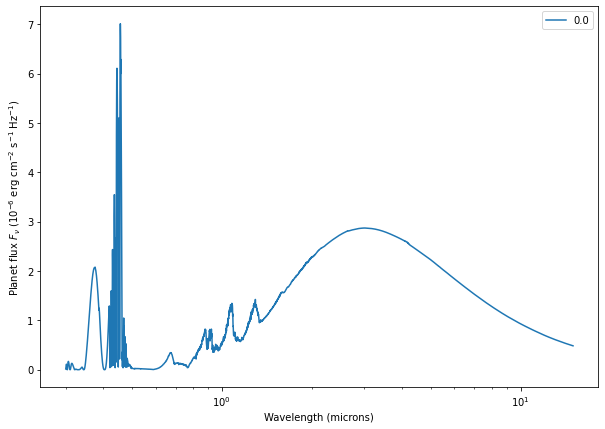

<Figure size 432x288 with 0 Axes>

In [6]:
for ind, ab in enumerate(abundances):
    print(ab)
    observation1, wlen, flux_nu, p1, t1 = Simulator([torch.ones(1)*2000.,torch.ones(1)*-2.0, torch.ones(1)*2.58,\
                                                    torch.ones(1)*ab[0], torch.ones(1)*ab[1], torch.ones(1)*ab[2],\
                                                    torch.ones(1)*ab[3], torch.ones(1)*ab[4], torch.ones(1)*ab[5],\
                                                    torch.ones(1)*ab[6], torch.ones(1)*ab[7]])
    
    # Spectrum
    
    plt.figure(figsize=(10,7))
    #plt.title(abund[ind])
    plt.plot(wlen/1e-4, flux_nu, label= str(np.round(ab[ind], 1)))
    plt.xscale('log')
    plt.xlabel('Wavelength (microns)')
    plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
    
    # PT profile
    
#     plt.plot(t1, p1, label= str(np.round(ab, 1)))
#     plt.yscale('log')
#     plt.ylim([1e2, 1e-6])
#     plt.ylabel('')
#     plt.xlabel('T (K)')
#     plt.ylabel('P (bar)')
    
    plt.legend()
    plt.show()
    plt.clf()
    break
    
# plt.legend()
# plt.show()
# plt.clf()